# Outlier Project  
[insert description]

## Import Libraries

In [38]:
import os
import glob
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, floor

from scipy.stats import chi2

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from joblib import Parallel, delayed

from xgboost import XGBClassifier

## Functions and Utilities

In [68]:
def inject_fixed_mahalanobis_outliers(X:pd.DataFrame, y, contamination_rate=0.01, distance_k=6.0, outlier_flag=None, random_state=42):
    """
    Injects multivariate outliers at a fixed Mahalanobis distance `distance_k`
    from the original data distribution (as measured by mean/cov).
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Target vector of shape (n_samples,).
    contamination_rate : float
        Fraction of points to replace with outliers.
    distance_k : float
        Desired Mahalanobis distance.
    outler_flag : string (default = None)
        Name of column that flags outlier. function will change it to 1
    random_state : int or None
        Seed for reproducibility.
    
    Returns
    -------
    X_new, y_new : np.ndarray, np.ndarray
        New feature matrix and target vector with outliers injected.
    """
    rng = np.random.default_rng(random_state)

    X_new = X.copy()
    y_new = y.copy()

    if outlier_flag and (outlier_flag in X.columns):
        X= X.drop(columns=[outlier_flag])

    n_samples, n_features = X.shape
    num_outliers = int(np.ceil(n_samples * contamination_rate))
    
    if num_outliers == 0:
        return X, y
    
    # Compute mean and covariance of the original data
    mu = X.mean(axis=0).values
    cov = np.cov(X, rowvar=False)  # shape: (n_features, n_features)
    
    # Cholesky decomposition for the data's covariance
    U = np.linalg.cholesky(cov)  # shape: (n_features, n_features)

    # Generate random unit vectors in bulk
    y_rand = rng.normal(size=(num_outliers, n_features))
    y_normed = y_rand / np.linalg.norm(y_rand, axis=1, keepdims=True)
    z = distance_k * y_normed  # Each row is a z vector
    X_outliers = mu + (z @ U.T)  # Apply transformation to all at once
    
    #Randomize the outlier labels from existing distribution
    y_outliers = rng.choice(y, size=num_outliers)

    # Create DataFrame with original column names
    X_outliers = pd.DataFrame(X_outliers, columns=X.columns)
    
    # Randomly choose which points in X to replace
    indices_to_replace = rng.choice(n_samples, size=num_outliers, replace=False)
    
    if outlier_flag:
        X_outliers[outlier_flag] = 1
    X_new.iloc[indices_to_replace, :] = X_outliers.values
    y_new[indices_to_replace] = y_outliers

    return X_new, y_new

In [13]:
def parse_filename(filename):
    """
    Extracts (sample_size, contamination) from filenames like:
    'df100.csv' or 'df100_contam5.csv'.
    If the pattern doesn't match, returns (None, None).
    """
    pattern = r"df(\d+)(?:_contam(\d+))?\.csv"
    match = re.search(pattern, filename)
    if not match:
        return None, None
    sample_size = int(match.group(1))
    contam_str = match.group(2)
    contamination = int(contam_str) if contam_str else 0
    return sample_size, contamination

In [14]:
def mahalanobis_distance_sq(X):
    """
    Computes the squared Mahalanobis distance for each row in X.
    Returns an array of shape (n_samples,).
    """
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    # Center the data
    diff = X - mu
    # Mahalanobis distance^2 = (x - mu)^T * inv_cov * (x - mu)
    md_sq = np.diag(diff @ inv_cov @ diff.T)
    return md_sq

In [51]:
def mahalanobis_distance_sq_2d(X2):
    """
    Same as above, but specifically for a 2D array X2.
    """
    mu = np.mean(X2, axis=0)
    cov = np.cov(X2, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    diff = X2 - mu
    md_sq = np.diag(diff @ inv_cov @ diff.T)
    return md_sq

if os.path.isfile("results.csv"):
    existing_results_df = pd.read_csv("results.csv")
else:
    existing_results_df = pd.DataFrame()

In [52]:
def contaminate_dataset(X_df, y, c, distance_k=6.0, outlier_flag=None, random_state=42):
    """
    Injects synthetic multivariate outliers into a dataset at a fixed Mahalanobis distance,
    for a given contamination rate. Returns a new DataFrame containing the contaminated data.

    Parameters
    ----------
    X_df : pd.DataFrame
        Feature matrix including all relevant columns (e.g., 'fea_*', 'is_outlier').
    y : np.ndarray
        Target vector of shape (n_samples,), typically from the 'trgt' column.
    c : float
        Contamination rate, i.e., the fraction of points in X to replace with outliers.
    distance_k : float, default=6.0
        The fixed Mahalanobis distance of each injected outlier from the data mean.
    outlier_flag : str or None
        If specified, this column will be set to 1 for outlier rows.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    c : float
        The same contamination rate used, useful for dictionary assignment.
    df_new : pd.DataFrame
        Contaminated version of X_df with outliers injected and target column reattached.
    """
    X_new, y_new = inject_fixed_mahalanobis_outliers(
        X_df, y,
        contamination_rate=c,
        distance_k=distance_k,
        outlier_flag=outlier_flag,
        random_state=random_state
    )

    df_new = X_new.copy()
    df_new["target"] = y_new
    return c, df_new

In [53]:
def generate_all_contaminated_datasets(original_data_dict, contamination_rates, distance_k=6.0, outlier_flag='is_outlier', random_state=42, n_jobs=-1):
    """
    Applies synthetic outlier injection across multiple datasets and contamination rates in parallel,
    returning a nested dictionary of contaminated datasets.

    Parameters
    ----------
    original_data_dict : dict
        Dictionary where keys are sample sizes (e.g., 100, 200) and values are pandas DataFrames.
        Each DataFrame should contain:
            - Feature columns prefixed with 'fea_'
            - Optional 'is_outlier' column
            - A target column named 'trgt'
    contamination_rates : list of float
        List of contamination rates to apply to each sample size.
    distance_k : float, default=6.0
        Mahalanobis distance to place injected outliers from the mean of the data distribution.
    outlier_flag : str or None, default='is_outlier'
        If specified, this column will be set to 1 for injected outliers.
    random_state : int, default=42
        Random seed for reproducibility.
    n_jobs : int, default=-1
        Number of parallel jobs to run. Use -1 to utilize all available CPU cores.

    Returns
    -------
    contaminated_data_dict : dict
        Nested dictionary of contaminated DataFrames structured as:
            {
                sample_size_1: {
                    contamination_rate_1: contaminated_df,
                    contamination_rate_2: contaminated_df,
                    ...
                },
                sample_size_2: {
                    ...
                },
                ...
            }
    """
    from joblib import Parallel, delayed

    contaminated_data_dict = {}

    for n, df in original_data_dict.items():
        # Split into features and target
        X_df = df.loc[:, df.columns.str.startswith('fea_') | (df.columns == outlier_flag)]
        y = df['trgt'].values

        results = Parallel(n_jobs=n_jobs)(
            delayed(contaminate_dataset)(X_df, y, c, distance_k=distance_k, outlier_flag=outlier_flag, random_state=random_state)
            for c in contamination_rates
        )

        contaminated_data_dict[n] = {c: df_new for c, df_new in results}

    return contaminated_data_dict

In [39]:
# We'll keep a global list to collect new results from each model
new_results_global = []

# Single scoring dictionary (shared by all models)
scoring_dict = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

In [30]:
sample_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
n_fea = 10
contamination_rates = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

## Constructing Datasets

In [ ]:
n = max(sample_sizes)
df = pd.DataFrame({"fea_0":np.random.normal(0,1,n),
                   "fea_1":np.random.normal(0,1,n),
                   "fea_2":np.random.normal(0,1,n),
                   "fea_3":np.random.normal(0,1,n),
                   "fea_4":np.random.normal(0,1,n),})
df['fea_5'] = df['fea_1']*df['fea_2'] - 0.5*df['fea_0'] + np.random.lognormal(0,0.1,n)
df['fea_6'] = df['fea_3'] + df['fea_4'] + np.random.normal(0,0.1,n)
df['fea_7'] = df['fea_2']*np.exp(df['fea_4']) + np.random.normal(1,0.42)
df['fea_5'] = (df['fea_5'] - df['fea_5'].mean()) / df['fea_5'].std() # Z-score standardization
df['fea_6'] = (df['fea_6'] - df['fea_6'].mean()) / df['fea_6'].std() # Z-score standardization
df['fea_7'] = (df['fea_7'] - df['fea_7'].mean()) / df['fea_7'].std() # Z-score standardization

df['y_int'] = df['fea_0']**2 + np.abs(df['fea_2'])**1.5 + (np.abs(df['fea_4'])**0.8)*df['fea_6'] + df['fea_5'] + np.random.lognormal(0,0.25,n)
df['trgt'] = (df['y_int'] >= 2.88).astype(float)
df['is_outlier'] = 0
df.drop(columns=['y_int'], inplace=True)


In [82]:
df

,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,y_int,trgt,is_outlier
0,-0.972130,0.696440,0.023325,1.119251,-0.245554,0.453850,0.622978,0.016843,2.500242,0.0,0
1,0.144946,-1.448045,-0.274708,0.605652,-0.231702,0.379572,0.334962,-0.074148,1.930697,0.0,0
2,-1.051147,-0.764912,1.289178,-1.138454,-0.731187,-0.412410,-1.308219,0.248919,1.849667,0.0,0
3,-1.360681,0.851817,1.070993,-1.128421,0.952225,1.347017,-0.243587,1.079268,5.190065,1.0,0
4,-0.284822,1.426533,-0.388911,-0.134028,-0.194586,-0.340039,-0.266625,-0.113548,1.137732,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.068071,-0.228585,-0.196393,-1.722719,0.582906,-0.009080,-0.898634,-0.125741,0.504654,0.0,0
9996,-0.793239,0.337337,-0.591470,-0.527352,0.266951,0.251606,-0.242403,-0.287833,2.461295,0.0,0
9997,-2.014975,1.920243,0.964757,-0.454609,1.077794,2.626905,0.466804,1.102077,8.869003,1.0,0
9998,-0.436619,3.003728,0.740006,-0.038323,-0.801017,2.071930,-0.590052,0.137806,2.979274,0.0,0


### Sample

In [84]:
sample_dict = {
    size: df.sample(n=size, random_state=42).reset_index(drop=True)
    for size in sample_sizes
}

In [85]:
sample_dict[500]

,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,y_int,trgt,is_outlier
0,-0.293521,-1.037099,-0.838897,0.843585,-1.164206,0.770441,-0.257719,-0.107713,2.304816,0.0,0
1,-0.285776,0.699434,0.091408,0.388523,0.712461,0.164731,0.752342,0.066720,1.898707,0.0,0
2,0.896939,-1.833974,-1.498297,0.618166,0.410352,2.120047,0.724823,-0.884652,6.633644,1.0,0
3,-0.006723,1.886254,-0.500640,-0.474041,0.533789,-0.754012,0.124965,-0.338044,0.799065,0.0,0
4,-0.233598,0.454031,0.670833,-0.072203,0.037405,0.223529,-0.046952,0.265187,1.567403,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
495,0.862439,0.125920,-2.425014,1.058636,-0.288866,-0.715065,0.440362,-0.712714,5.092865,1.0,0
496,-1.488351,-0.829429,2.105003,-1.057515,-1.851705,-0.993287,-1.918003,0.122772,2.635428,0.0,0
497,0.658723,1.552288,-0.537653,-1.100741,0.558746,-1.112200,-0.459087,-0.371624,0.772770,0.0,0
498,1.417965,0.016034,-0.353869,0.013802,0.813485,-0.607260,0.440822,-0.316431,2.953340,1.0,0


## Contamination

In [86]:
contaminated_data_dict = {}


In [87]:
contaminated_data_dict = generate_all_contaminated_datasets(
    sample_dict,
    contamination_rates,
    distance_k=6.0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [88]:
contaminated_data_dict[1000].keys()

dict_keys([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

## Data Viz

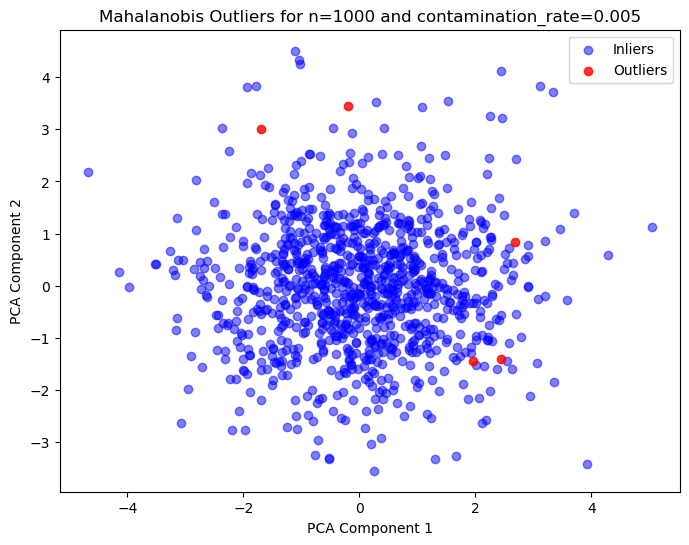

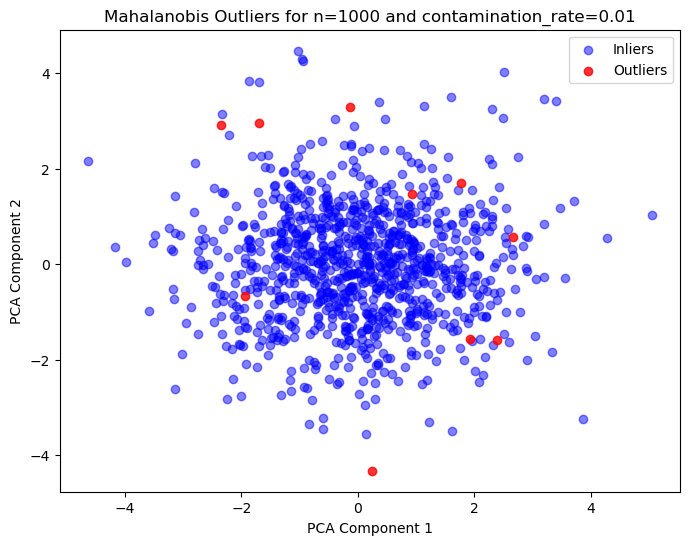

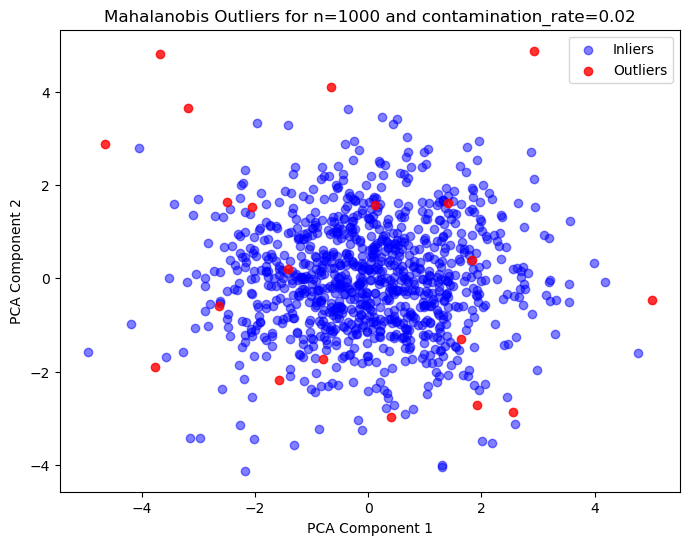

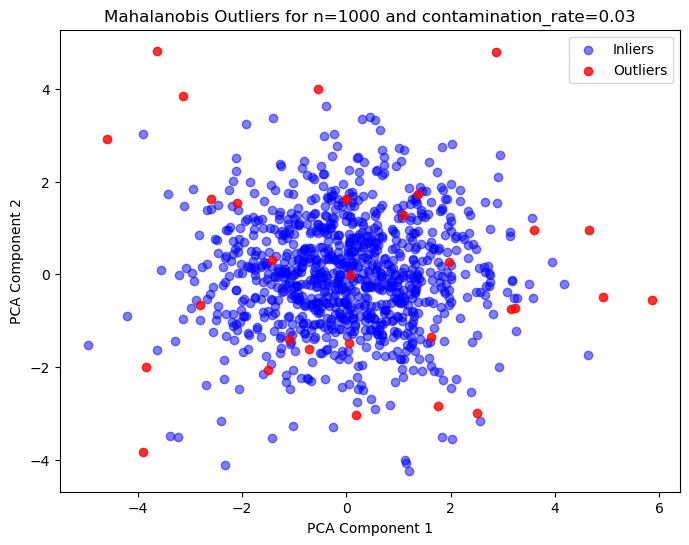

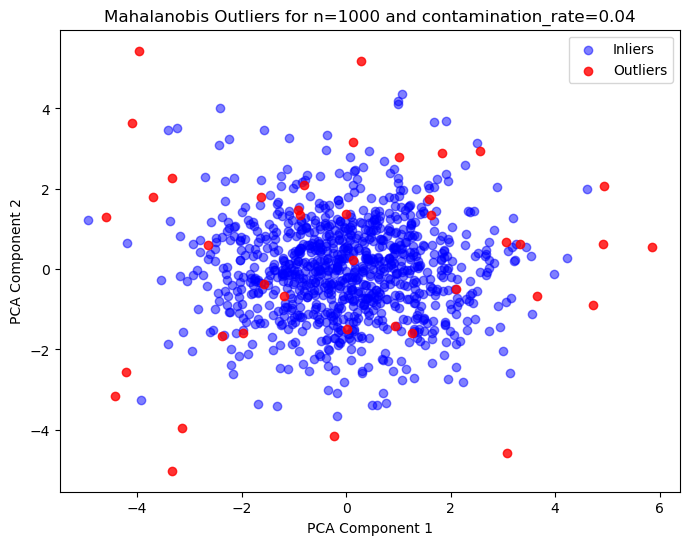

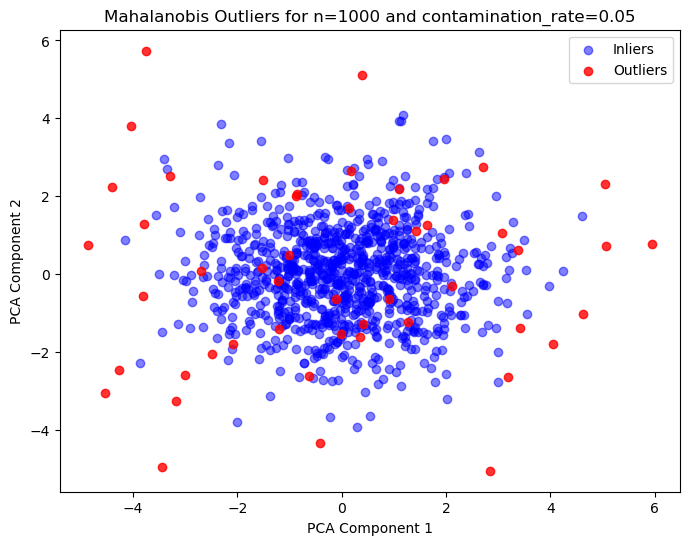

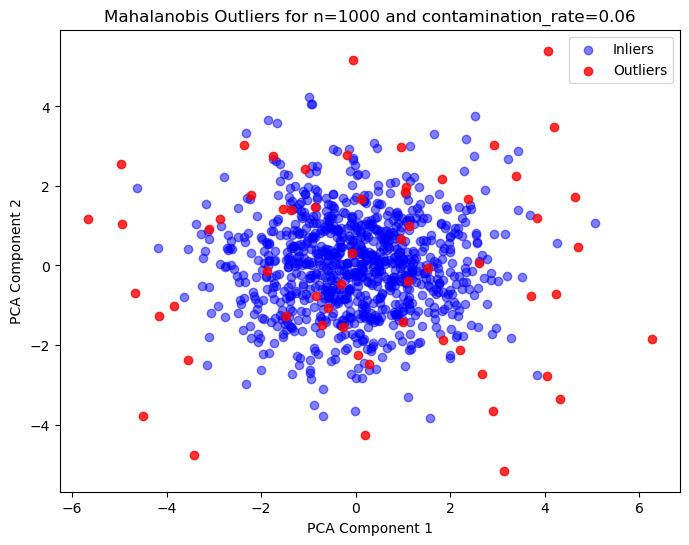

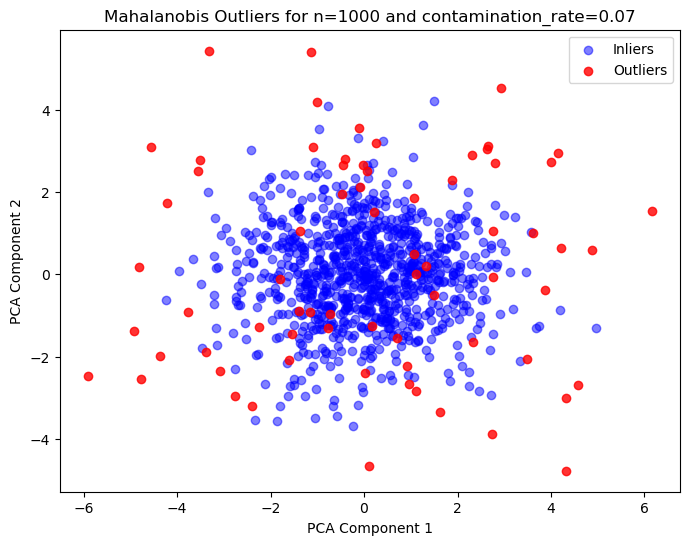

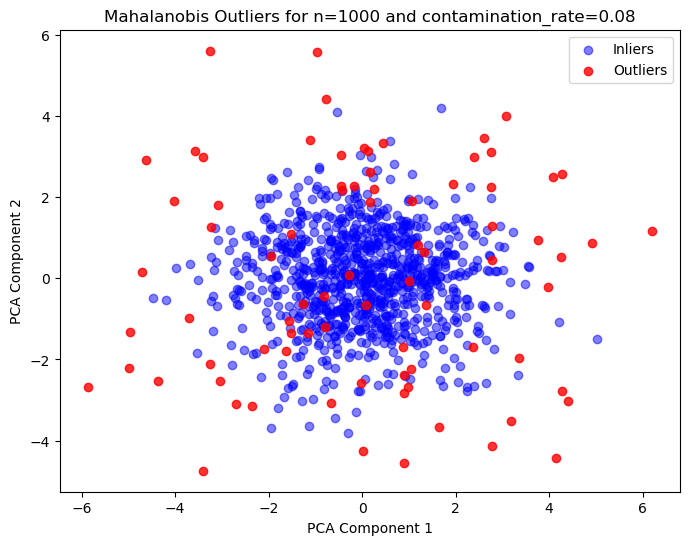

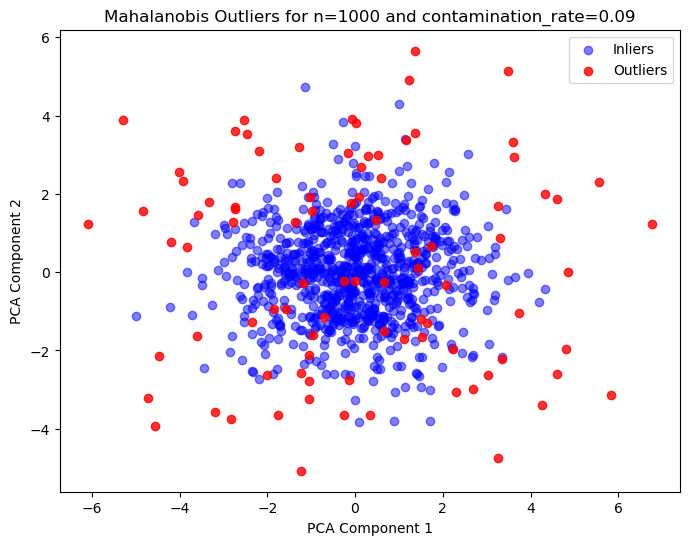

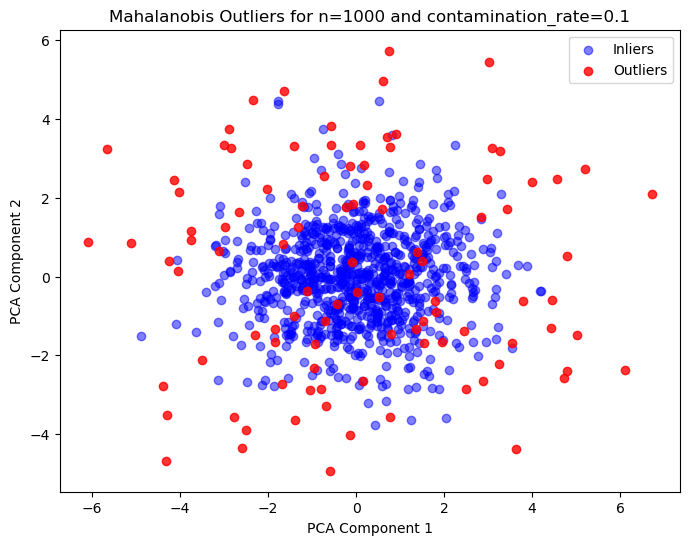

In [89]:
for sample_size, inner_dict in contaminated_data_dict.items():
    if sample_size == 1000:
        for contamination_rate, df in inner_dict.items():
            X = df.loc[:, df.columns.str.startswith('fea_')]
            outlier_mask = df['is_outlier']>0
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            plt.figure(figsize=(8, 6))
            plt.title(f"Mahalanobis Outliers for n={sample_size} and contamination_rate={contamination_rate}")
            
            # Inliers in blue
            plt.scatter(
                X_pca[~outlier_mask, 0],
                X_pca[~outlier_mask, 1],
                c='blue', alpha=0.5, label='Inliers'
            )
            # Outliers in red
            plt.scatter(
                X_pca[outlier_mask, 0],
                X_pca[outlier_mask, 1],
                c='red', alpha=0.8, label='Outliers'
            )
    
            plt.legend()
            plt.xlabel("PCA Component 1")
            plt.ylabel("PCA Component 2")
            plt.show()